# ОПИСАНИЕ ГИБРИДНОЙ РЕКОМЕНДАТЕЛЬНОЙ СИСТЕМЫ
Рекомендательная система состоит из 4 блоков:

*   **коллаборативная фильтрация** (совместная фильтрация) - **80%** рекомендованного контента
*   **content based** фильтрация (семантически связанная фильтрация) - **20%** рекомендованного контента
*   **холодный старт: популярные каналы** (случайная ротация) рекомендованного контента - для холодного старта коллаборативной фильтрации
*   **холодный старт: каналы с высоким % лайков** (случайная ротация) рекомендованного контента - для холодного старта коллаборативной фильтрации



# ИМПОРТ



In [ ]:
pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann

In [ ]:
import os
import re
import time
import pandas as pd
import numpy as np
import pprint
import tempfile
from typing import Dict, Text

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/HACKATHONS/Видеопереворот/Рекомендательная система/files/'

# Обезличенная база данных взаимодействия пользователей с видео-контентом (лайки, просмотры, комментарии, загрузки и пр.) 
video_dataset = 'video_dataset.csv'

# Обезличеная база данных видеоконтента 
concurs_data = 'concurs_data.csv'

# ИССЛЕДУЕМ ДАННЫЕ

## video_dataset.csv

In [ ]:
df_video = pd.read_csv(PATH + video_dataset)

### Общая информация

In [ ]:
df_video.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1501738 entries, 0 to 1501737
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1501738 non-null  int64 
 1   user_id     1501738 non-null  object
 2   log_time    1501738 non-null  object
 3   video_id    1501738 non-null  object
 4   action      1501738 non-null  object
dtypes: int64(1), object(4)
memory usage: 57.3+ MB


In [ ]:
df_video.head()

,Unnamed: 0,user_id,log_time,video_id,action
0,0,4221d84f95dee655ee2550260bd17374,2023-01-01T11:12:20,e7eed8c700fee9616d4b4369c90b0605,video/create-comment
1,1,4221d84f95dee655ee2550260bd17374,2023-01-01T11:19:59,1302f5e72c250231eb3849190dea8b00,video/create-comment
2,2,4221d84f95dee655ee2550260bd17374,2023-01-01T11:23:42,8001da945d4d8f656ad4ef8a7097bd3f,video/create-comment
3,3,4221d84f95dee655ee2550260bd17374,2023-01-01T11:26:20,cf6e2f15bd44f7d34c5c3f472d942416,video/create-comment
4,4,4221d84f95dee655ee2550260bd17374,2023-01-01T11:29:25,84842cc267ccf4ad7d00a143386194fd,video/create-comment


### Виды взаимодействий (action)

In [ ]:
df_video['action'].unique()

array(['video/create-comment', 'donate', 'video/emotion', 'video/upload',
       'video/view'], dtype=object)

### Пропуски

In [ ]:
df_video.isnull().sum()

Unnamed: 0    0
user_id       0
log_time      0
video_id      0
action        0
dtype: int64

### Количество дубликатов

In [ ]:
df_video.duplicated(keep=False).sum()

0

### Посмотрим распределение просмотров

In [ ]:
df_user_count = df_video.groupby(['user_id']).agg({'user_id':'count'})
df_user_count.columns = ['count']
df_user_count_sort = df_user_count.sort_values(by='count', ascending=False)

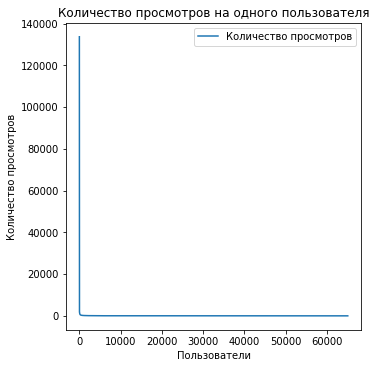

In [ ]:
x = np.linspace(0, df_user_count_sort.shape[0], df_user_count_sort.shape[0]) 
y = df_user_count_sort['count'].to_numpy()

fig, ax = plt.subplots(figsize=(5, 5), layout='constrained')
ax.plot(x, y, label='Количество просмотров')  # Plot some data on the axes.
ax.set_xlabel('Пользователи')  # Add an x-label to the axes.
ax.set_ylabel('Количество просмотров')  # Add a y-label to the axes.
ax.set_title("Количество просмотров на одного пользователя")  # Add a title to the axes.
ax.legend()  # Add a legend.

#### Логарифм

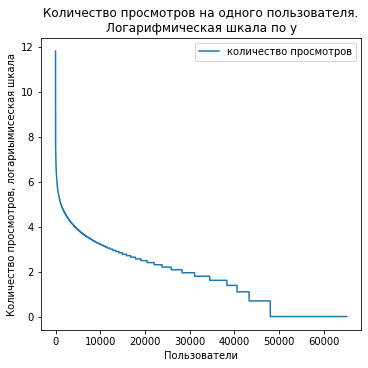

In [ ]:
y_log = np.log(y)

fig, ax = plt.subplots(figsize=(5, 5), layout='constrained')
ax.plot(x, y_log, label='количество просмотров')  # Plot some data on the axes.
ax.set_xlabel('Пользователи')  # Add an x-label to the axes.
ax.set_ylabel('Количество просмотров, логариымисеская шкала')  # Add a y-label to the axes.
ax.set_title("Количество просмотров на одного пользователя.\nЛогарифмическая шкала по y")  # Add a title to the axes.
ax.legend()  # Add a legend.

## concurs_data.csv

In [ ]:
df_concurs = pd.read_csv(PATH + concurs_data)

### Общая информация

In [ ]:
df_concurs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   _key           100000 non-null  int64 
 1   channel_name   99963 non-null   object
 2   comment_count  100000 non-null  int64 
 3   description    95205 non-null   object
 4   dislike_count  100000 non-null  int64 
 5   duration       100000 non-null  int64 
 6   fulltitle      100000 non-null  object
 7   like_count     100000 non-null  int64 
 8   tags           100000 non-null  object
 9   upload_date    100000 non-null  int64 
 10  uploader_url   99998 non-null   object
 11  view_count     100000 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 9.2+ MB


In [ ]:
df_concurs.head()

,_key,channel_name,comment_count,description,dislike_count,duration,fulltitle,like_count,tags,upload_date,uploader_url,view_count
0,21350050,ZO'R TV,135,Официальный сайт: http://www.zortv.uz\nZO'RTV ...,0,1742,Bitta savol bor 1- son (10.07.2018),437,"[""zo'r tv"" 'zor tv' 'зур тв' 'зор тв']",1531170000,http://www.youtube.com/channel/UCisKdSbTsPt16y...,35735
1,71990270,Мир Белогорья,0,ЧП произошло в Краснояружском Староселье. Напо...,0,36,Супружеская пара подорвалась на боеприпасе неу...,23,['белгород' 'белгородская область' 'белгород н...,1669064400,http://www.youtube.com/@mirbelogor,931
2,61570019,Спорт-Экспресс,45,"Российский лыжник рассказал, каково чувствоать...",0,387,"Сергей Устюгов: «На горе может выключить так, ...",644,[],1578085200,http://www.youtube.com/user/sportexpress,30898
3,22003727,Extra News,0,Министр иностранных дел Венгрии Петер Сийярто ...,0,155,Венгрия удостоила Мантурова высшей госнаграды ...,1,['Новости' 'События' 'политика' 'народы'],1625691600,http://www.youtube.com/channel/UCYasXPsHhTVsn5...,63
4,28432077,Твой Дом - Тюрьма,0,Обязательно подпишитесь на наш канал! Воры в з...,0,220,"Коронован ""Дедом Хасаном"", воевал с Монголом. ...",63,['воры в законе 2019' 'криминал' 'киллеры' 'бл...,1560805200,http://www.youtube.com/user/max17111,18455


### Пропуски

In [ ]:
df_concurs.isnull().sum()

_key                0
channel_name       37
comment_count       0
description      4795
dislike_count       0
duration            0
fulltitle           0
like_count          0
tags                0
upload_date         0
uploader_url        2
view_count          0
dtype: int64

### Количество дубликатов

In [ ]:
df_concurs.duplicated(keep=False).sum()

0

## Выводы исследования данных

*   датасет **video_dataset.csv** достаточный для построения **коллаборативной рекомендательной системы**, пропусков нет, все виды actions ['video/create-comment', 'donate', 'video/emotion', 'video/upload', 'video/view'] можно считать элементами заинтересованого взаимодействия, в том числе и загрузку видео;
*   датасет **concurs_data.csv** достаточный для построения **item to item** рекоментательной системы и рекомендаций на основе случайной ротации популярных каналов и каналов с высоким % лайков для холодного старта (новый посетитель, не имеющий приемлимой истории);



# КОЛЛАБОРАТИВНАЯ ФИЛЬТРАЦИЯ НА ОСНОВЕ TFRS

## Обработка данных
Удаление дубликатов и NaN - не делаем, их нет.

### Отбираем 1000 популярных видео по взаимодействию

In [ ]:
df_video_1000 = df_video.groupby(['video_id']).size().sort_values(ascending=False)[0:1000]
df_video_1000.columns = ['video_id', 'count']

In [ ]:
df_video_1000.head()

video_id
6d09d9256bab63c1dd8c8c9f925c6988    43451
741aabf3d662046eed9aee200e9af124    42755
c7acb9ac7101ac340a98522233bb46b3    13240
51ac02fdad9f8626d9978be3990f933b    13100
7a8b73650acba4ba80bf7cb121409ff3     8595
dtype: int64

In [ ]:
df_video_1000.index

Index(['6d09d9256bab63c1dd8c8c9f925c6988', '741aabf3d662046eed9aee200e9af124',
       'c7acb9ac7101ac340a98522233bb46b3', '51ac02fdad9f8626d9978be3990f933b',
       '7a8b73650acba4ba80bf7cb121409ff3', '24643557271e2288d47b61921c7fcc91',
       'f1572896571e15a5298949620742b824', 'f63804ea643d094376ac4001aa523c7f',
       'ff22ef62469e284cf80dbd36dd956b07', 'ac30f6e6deeadce869623836cc218fad',
       ...
       '083164ba14381ee56040710a8e465ec4', '207f4ab2b4ad554815375226cfa18373',
       '425f7447561e99c54252c221d26c1d60', 'dd8298f1e547597a46204ba96da0d1d2',
       'b9dbc9f6a2833a4c078020f155ceb0a5', '7a3dfbac8a289a67bbce79394140a5ef',
       'b0737dbd7f6be0cb0a773cc233e06d9c', 'bac3f56bcfeb5fb744b199fe54645c2a',
       '6acef9471ca871586f55a6ad287e63e5', '69a057e403c249540aa80a7810581c90'],
      dtype='object', name='video_id', length=1000)

In [ ]:
reducer = df_video['video_id'].isin(df_video_1000.index)
df_video_2 = df_video[reducer]
print(f'Строк до фильтрации: {df_video.shape[0]}, после: {df_video_2.shape[0]}')

Строк до фильтрации: 1501738, после: 583446


## Подготавливаем данные для моделей

### Получаем tf датасет уникальных пользователей

In [ ]:
users_id_arr = df_video['user_id'].astype('bytes').unique()
users_id_arr

array([b'4221d84f95dee655ee2550260bd17374',
       b'7d835b9ffdd0b50f98ea2a617c4181f5',
       b'311b155f3bd5a812edf84226c8faf8d2', ...,
       b'e32dfb0dcef4f6afabe4371bfb5ca0bf',
       b'6a710d9e3f1509ff612c8f273d26a4e6',
       b'13c1d276a8c56f06077e35e28689379f'], dtype='|S32')

### Получаем tf датасет уникальных видео

In [ ]:
videos_id_arr = df_video['video_id'].astype('bytes').unique()
videos_id_arr

array([b'e7eed8c700fee9616d4b4369c90b0605',
       b'1302f5e72c250231eb3849190dea8b00',
       b'8001da945d4d8f656ad4ef8a7097bd3f', ...,
       b'f19b0c28662368dd064d8a2d98059838',
       b'e48e4408520605fc1c0fdb820181d23f',
       b'1496720aaa6746067d9371c7ab6b54e5'], dtype='|S32')

In [ ]:
videos_tensor = tf.data.Dataset.from_tensor_slices(videos_id_arr)

### Получаем tf датасет ratings

In [ ]:
ratings_ser = df_video['user_id']
df_ratings = pd.DataFrame(ratings_ser)
df_ratings['video_id'] = df_video['video_id']
df_ratings.shape

(1501738, 2)

In [ ]:
df_ratings.head()

,user_id,video_id
0,4221d84f95dee655ee2550260bd17374,e7eed8c700fee9616d4b4369c90b0605
1,4221d84f95dee655ee2550260bd17374,1302f5e72c250231eb3849190dea8b00
2,4221d84f95dee655ee2550260bd17374,8001da945d4d8f656ad4ef8a7097bd3f
3,4221d84f95dee655ee2550260bd17374,cf6e2f15bd44f7d34c5c3f472d942416
4,4221d84f95dee655ee2550260bd17374,84842cc267ccf4ad7d00a143386194fd


In [ ]:
ratings_b_arr = df_ratings.to_numpy().astype('bytes')

In [ ]:
ratings = tf.data.Dataset.from_tensor_slices({"video_id": ratings_b_arr[:, 1], "user_id": ratings_b_arr[:, 0]})
ratings

<TensorSliceDataset element_spec={'video_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None)}>

### Перемешиваем выборку

In [ ]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(df_ratings.shape[0], seed=42, reshuffle_each_iteration=False)

### Определяем длину учебной и тестовой выбоки

In [ ]:
len(shuffled)

1501738

In [ ]:
if len(shuffled) > 10000 :
  train_num = 10000
  test_num = 2000
else:
  train_num = round(len(shuffled) * 0.8)
  test_num = len(shuffled) - train_num

### Разбиваем выборку на учебную и тестовую

In [ ]:
# Разбиваем выборку на учебную и тестовую
train = shuffled.take(train_num)
test = shuffled.skip(train_num).take(test_num)

In [ ]:
print(train)

<TakeDataset element_spec={'video_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None)}>


In [ ]:
print(len(train))
print(len(test))

10000
2000


## Модель

### Размер вектора сжатого признакового пространства

In [ ]:
embedding_dimension = 64

### Башня запросов

In [ ]:
user_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(vocabulary=users_id_arr, mask_token=None),
  tf.keras.layers.Embedding(len(users_id_arr) + 1, embedding_dimension)
])

### Башня кандидатов

In [ ]:
movie_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(vocabulary=videos_id_arr, mask_token=None),
  tf.keras.layers.Embedding(len(videos_id_arr) + 1, embedding_dimension)
])

### Метрики

In [ ]:
# Вычисляет показатели для K лучших кандидатов, обнаруженных моделью поиска
metrics = tfrs.metrics.FactorizedTopK(
  # Применяем к батчу данных videos_tensor нашу модель кандидата
  candidates = videos_tensor.batch(1000).map(movie_model)
)

### Ошибки

In [ ]:
task = tfrs.tasks.Retrieval(
  metrics = metrics
)

### Полная модель

In [ ]:
class MovielensModel(tfrs.Model):
  def __init__(self, user_model, movie_model):
    super().__init__()
    self.movie_model: tf.keras.Model = movie_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # Выбираем пользовательские функции и передаем их в пользовательскую модель.
    user_embeddings = self.user_model(features["user_id"])
    # И выберите функции фильма и передайте их в модель фильма,
    # вернуть вложения.
    positive_movie_embeddings = self.movie_model(features["video_id"])

    # Вычисляет потери и метрики.
    return self.task(user_embeddings, positive_movie_embeddings)

In [ ]:
model = MovielensModel(user_model, movie_model)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

In [ ]:
cached_train = train.shuffle(10_000).batch(32).cache()
cached_test = test.batch(32).cache()

In [ ]:
print(train)
print(cached_train)

<TakeDataset element_spec={'video_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None)}>
<CacheDataset element_spec={'video_id': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'user_id': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>


## Обучим модель

In [ ]:
# По сути это вычисление матрицы и после того, как она вычислится в теории - дальнейшие эпохи мало скажутся на точности.
history = model.fit(cached_train, epochs=3)

Epoch 1/3


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


313/313 [==============================] - 323s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0077 - factorized_top_k/top_5_categorical_accuracy: 0.0901 - factorized_top_k/top_10_categorical_accuracy: 0.1249 - factorized_top_k/top_50_categorical_accuracy: 0.1492 - factorized_top_k/top_100_categorical_accuracy: 0.1546 - loss: 101.2412 - regularization_loss: 0.0000e+00 - total_loss: 101.2412
Epoch 2/3
313/313 [==============================] - 299s 954ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0210 - factorized_top_k/top_5_categorical_accuracy: 0.2214 - factorized_top_k/top_10_categorical_accuracy: 0.3155 - factorized_top_k/top_50_categorical_accuracy: 0.4988 - factorized_top_k/top_100_categorical_accuracy: 0.5600 - loss: 71.4983 - regularization_loss: 0.0000e+00 - total_loss: 71.4983
Epoch 3/3
313/313 [==============================] - 312s 998ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0739 - factorized_top_k/top_5_categorical_accuracy: 0.8050 - fa

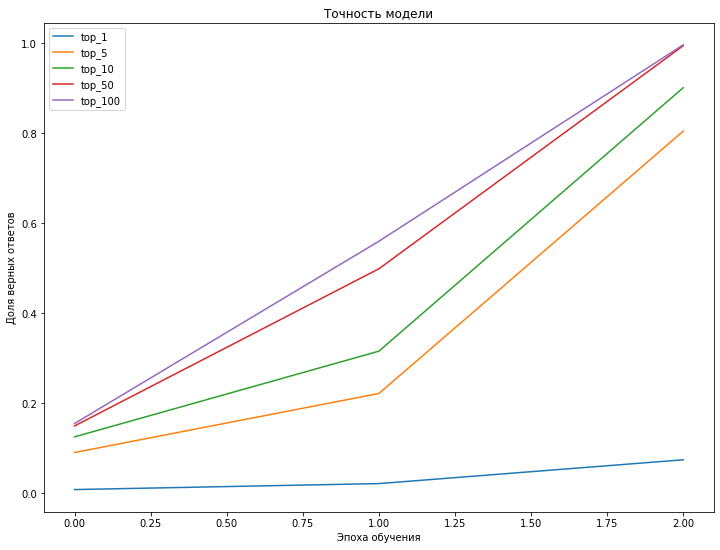

In [ ]:
# Оображаем график точности обучения
plt.figure(figsize=(12, 9))
plt.title('Точность модели')
plt.plot(history.history['factorized_top_k/top_1_categorical_accuracy'])
plt.plot(history.history['factorized_top_k/top_5_categorical_accuracy'])
plt.plot(history.history['factorized_top_k/top_10_categorical_accuracy'])
plt.plot(history.history['factorized_top_k/top_50_categorical_accuracy'])
plt.plot(history.history['factorized_top_k/top_100_categorical_accuracy'])
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend(['top_1', 'top_5', 'top_10', 'top_50', 'top_100'])
plt.show()

## Оценка модели

In [ ]:
model.evaluate(cached_test, return_dict=True)

63/63 [==============================] - 61s 941ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0240 - factorized_top_k/top_5_categorical_accuracy: 0.0785 - factorized_top_k/top_10_categorical_accuracy: 0.0910 - factorized_top_k/top_50_categorical_accuracy: 0.1890 - factorized_top_k/top_100_categorical_accuracy: 0.1950 - loss: 97.0144 - regularization_loss: 0.0000e+00 - total_loss: 97.0144


{'factorized_top_k/top_1_categorical_accuracy': 0.024000000208616257,
 'factorized_top_k/top_5_categorical_accuracy': 0.07850000262260437,
 'factorized_top_k/top_10_categorical_accuracy': 0.09099999815225601,
 'factorized_top_k/top_50_categorical_accuracy': 0.1889999955892563,
 'factorized_top_k/top_100_categorical_accuracy': 0.19499999284744263,
 'loss': 35.79358673095703,
 'regularization_loss': 0,
 'total_loss': 35.79358673095703}

## Получаем рекомендации

In [ ]:
# Создаём индекс - BruteForce означает что мы делаем исчерпывающий поиск соседей вектора вложения
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)

# Рекомендует фильмы из всего набора данных фильмов.
index.index_from_dataset(
  tf.data.Dataset.zip((videos_tensor.batch(1000), videos_tensor.batch(1000).map(model.movie_model)))
)

# Получить рекомендации для пользователя с индексом "4221d84f95dee655ee2550260bd17374".
_, titles = index(tf.constant(["4221d84f95dee655ee2550260bd17374"]))
print(f"Рекомендации для пользователя 4221d84f95dee655ee2550260bd17374: {titles[0, :5]}")

Рекомендации для пользователя 4221d84f95dee655ee2550260bd17374: [b'e79a76ee372bfee5b74b9b9f2d46b553' b'119c22383be10ce32d4c96d90bb202e1'
 b'f4a31d5fc29fa09f57653415c140dd45' b'af6922383ef051437901b8fbb5db80a5'
 b'370c4d38c6bcff9657ccbc3748777438']


In [ ]:
rec_videos_id_list = titles.numpy().astype('str').tolist()

In [ ]:
rec_videos_id_list

[['e79a76ee372bfee5b74b9b9f2d46b553',
  '119c22383be10ce32d4c96d90bb202e1',
  'f4a31d5fc29fa09f57653415c140dd45',
  'af6922383ef051437901b8fbb5db80a5',
  '370c4d38c6bcff9657ccbc3748777438',
  'f19d9f4987075308c4c3c3f2939844e5',
  '6040d2c4d176af0100edf5ff04531d82',
  '112e7e5e8bdc697452dba854c2b7b07e',
  '0b1b483c9d776933e0881dde6541b022',
  'dd14694bc7053fb5c7dcca286b420a33']]

## Сохраним модель

In [ ]:
index.save(PATH + 'model')

In [ ]:
# Загрузим модель
loaded = tf.keras.models.load_model(PATH + 'model')

In [ ]:
scores, titles = loaded(["4221d84f95dee655ee2550260bd17374"])

In [ ]:
scores

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[13.566871, 10.713418, 10.421684, 10.38669 ,  9.635106,  9.138958,
         8.607918,  8.217784,  7.839151,  7.652847]], dtype=float32)>

In [ ]:
titles

<tf.Tensor: shape=(1, 10), dtype=string, numpy=
array([[b'e79a76ee372bfee5b74b9b9f2d46b553',
        b'119c22383be10ce32d4c96d90bb202e1',
        b'f4a31d5fc29fa09f57653415c140dd45',
        b'af6922383ef051437901b8fbb5db80a5',
        b'370c4d38c6bcff9657ccbc3748777438',
        b'f19d9f4987075308c4c3c3f2939844e5',
        b'6040d2c4d176af0100edf5ff04531d82',
        b'112e7e5e8bdc697452dba854c2b7b07e',
        b'0b1b483c9d776933e0881dde6541b022',
        b'dd14694bc7053fb5c7dcca286b420a33']], dtype=object)>

In [ ]:
print(f"Recommendations: {titles[0][:3]}")

Recommendations: [b'e79a76ee372bfee5b74b9b9f2d46b553' b'119c22383be10ce32d4c96d90bb202e1'
 b'f4a31d5fc29fa09f57653415c140dd45']


## Подключение ScaNN

### Оценим время ответа

In [ ]:
%timeit _, titles = index(tf.constant(["4221d84f95dee655ee2550260bd17374"]), k=10)

2.89 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### ScaNN

In [ ]:
scann = tfrs.layers.factorized_top_k.ScaNN(model.user_model)

# Рекомендует фильмы из всего набора данных фильмов.
scann.index_from_dataset(
  tf.data.Dataset.zip((videos_tensor.batch(1000), videos_tensor.batch(1000).map(model.movie_model)))
)

In [ ]:
%timeit _, titles = scann(tf.constant(["4221d84f95dee655ee2550260bd17374"]), k=10)

4.29 ms ± 368 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
titles

<tf.Tensor: shape=(1, 10), dtype=string, numpy=
array([[b'e79a76ee372bfee5b74b9b9f2d46b553',
        b'119c22383be10ce32d4c96d90bb202e1',
        b'f4a31d5fc29fa09f57653415c140dd45',
        b'af6922383ef051437901b8fbb5db80a5',
        b'370c4d38c6bcff9657ccbc3748777438',
        b'f19d9f4987075308c4c3c3f2939844e5',
        b'6040d2c4d176af0100edf5ff04531d82',
        b'112e7e5e8bdc697452dba854c2b7b07e',
        b'0b1b483c9d776933e0881dde6541b022',
        b'dd14694bc7053fb5c7dcca286b420a33']], dtype=object)>